# Importing and Visualizing the Dataset

Total training image count: 5184
Found 5184 files belonging to 2 classes.
Using 4148 files for training.
Found 5184 files belonging to 2 classes.
Using 1036 files for validation.
Found 80 files belonging to 2 classes.


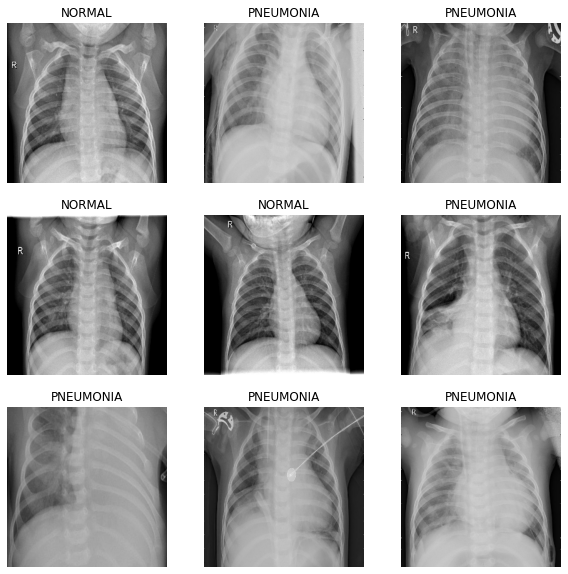

In [34]:
import pathlib
import PIL
import matplotlib.pyplot as plt
from tensorflow import keras

data_dir = pathlib.Path("./chest_xray/train/")
test_dir = pathlib.Path("./chest_xray/test/")
val_dir = pathlib.Path("./chest_xray/val/")
image_count = len(list(data_dir.glob('*/*.jpeg')))
print("Total training image count:", image_count)

norm = list(data_dir.glob("NORMAL/*"))
pneum = list(data_dir.glob("PNEUMONIA/*"))

dataset = keras.preprocessing.image_dataset_from_directory(data_dir, batch_size=32, validation_split=0.2, subset="training", seed=0)
test_data = keras.preprocessing.image_dataset_from_directory(data_dir, batch_size=32, validation_split=0.2, subset="validation", seed=0)
val_data = keras.preprocessing.image_dataset_from_directory(val_dir, batch_size=32, seed=0)

#test_dataset = keras.preprocessing.image_dataset_from_directory(test_dir, batch_size=32)

plt.figure(figsize=(10, 10))
for images, labels in dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(dataset.class_names[labels[i]])
    plt.axis("off")

# Caching the Dataset to Memory

In [35]:
dataset = dataset.cache().shuffle(1000).prefetch(buffer_size=32)
val_data = val_data.cache().shuffle(1000).prefetch(buffer_size=32)

# Augmenting the Data to Reduce Overfitting

In [36]:
from tensorflow.keras import layers

data_augmentor = keras.Sequential([
    layers.experimental.preprocessing.Resizing(256,256),
    layers.experimental.preprocessing.Rescaling(1./255),

    layers.experimental.preprocessing.RandomFlip("horizontal"),
    # Other preprocessing transformations cause the model to crash. Look into this.
    #layers.experimental.preprocessing.RandomRotation(0.1),
    #layers.experimental.preprocessing.RandomZoom(0.1)
])

# Initializing the Network Layers

In [37]:
from tensorflow.keras import layers

model = keras.Sequential([
    

    data_augmentor,

    layers.Conv2D(32, 3, padding='same', activation="relu"),
    layers.MaxPooling2D(),

    layers.Conv2D(32, 3, padding='same', activation="relu"),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, padding='same', activation="relu"),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(128,activation="relu"),
    layers.Dropout(0.5),

    layers.Dense(1, activation="sigmoid")
])

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["binary_accuracy"]
)

#model.summary()

# Training the Model

In [38]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=5,
    min_delta=0.001,
    restore_best_weights=True,
)

epochs=30
history = model.fit(
  dataset,
  validation_data=val_data,
  epochs=epochs,
  callbacks=[early_stopping]
)

Epoch 1/30
130/130 [==============================] - 85s 655ms/step - loss: 0.3155 - binary_accuracy: 0.8717 - val_loss: 0.7765 - val_binary_accuracy: 0.7250
Epoch 2/30
130/130 [==============================] - 86s 660ms/step - loss: 0.1383 - binary_accuracy: 0.9491 - val_loss: 0.6553 - val_binary_accuracy: 0.7625
Epoch 3/30
130/130 [==============================] - 89s 682ms/step - loss: 0.1070 - binary_accuracy: 0.9597 - val_loss: 0.5615 - val_binary_accuracy: 0.7750
Epoch 4/30
130/130 [==============================] - 88s 680ms/step - loss: 0.0902 - binary_accuracy: 0.9711 - val_loss: 0.8919 - val_binary_accuracy: 0.7125
Epoch 5/30
130/130 [==============================] - 87s 673ms/step - loss: 0.0885 - binary_accuracy: 0.9696 - val_loss: 0.4415 - val_binary_accuracy: 0.8375
Epoch 6/30
130/130 [==============================] - 88s 676ms/step - loss: 0.0662 - binary_accuracy: 0.9761 - val_loss: 0.8280 - val_binary_accuracy: 0.8000
Epoch 7/30
130/130 [==========================

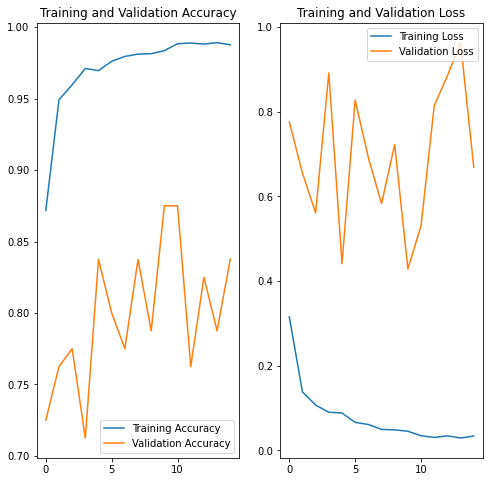

In [39]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(max(history.epoch)+1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Evaluating on Test Data

In [40]:
results = model.evaluate(test_data)
print("Test loss, Test accuracy:", results)

33/33 [==============================] - 9s 272ms/step - loss: 0.0950 - binary_accuracy: 0.9730
Test loss, Test accuracy: [0.09503063559532166, 0.9729729890823364]
